In [53]:
import pandas as pd
import numpy as np
import time
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [54]:
TRAIN_FILE_PATH = './archive/train.csv'

data = pd.read_csv(TRAIN_FILE_PATH)

In [55]:
#Id en Name zijn niet relevant voor het model
data = data.drop(['PassengerId', 'Name'], axis=1)

In [56]:
data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [57]:
#print gemiddelde age van wel en niet getransporteerde mensen
print(data.groupby('Transported')['Age'].mean())
#Percentage vips per 
print(data.groupby('Transported')['VIP'].mean())
#Percentage van de mensen die getransporteerd zijn per destination
print(data.groupby('Destination')['Transported'].mean())

Transported
False    29.922858
True     27.748834
Name: Age, dtype: float64
Transported
False    0.029175
True     0.017782
Name: VIP, dtype: float64
Destination
55 Cancri e      0.610000
PSO J318.5-22    0.503769
TRAPPIST-1e      0.471175
Name: Transported, dtype: float64


In [58]:
data = data.sample(frac=1)
train_data = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]

train_x = train_data.drop(['Transported'], axis=1)
train_y = train_data['Transported']

test_x = test_data.drop(['Transported'], axis=1)
test_y = test_data['Transported']

#encode the data using sklearn.preprocessing.LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_x = train_x.apply(le.fit_transform)
test_x = test_x.apply(le.fit_transform)

In [59]:
param_grid = {'C': [0.1, 1, 10, 100],
                'degree': [0, 3, 6],
                'kernel':['poly', 'rbf', 'sigmoid']}

iterations = 15

grid = GridSearchCV(SVC(), param_grid, refit=True, cv=iterations, verbose=3, n_jobs=-1)

start = time.time()

grid.fit(train_x, train_y)

end = time.time()

print(f"Training time: {end - start}s")

Fitting 15 folds for each of 36 candidates, totalling 540 fits
Training time: 314.2259027957916s


In [60]:
best_score = grid.best_score_
best_params = grid.best_params_

with open('result.txt', 'a') as f:
    f.write(f"GridSearch icm SVC\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Best score: {best_score}\n")
    f.write(f"Best params: {best_params}\n")
    f.write(f"Training time: {end - start}s\n\n")

In [61]:
gs_results = pd.DataFrame(grid.cv_results_)
gs_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
gs_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
28,2.689187,0.189785,0.156909,0.014455,100,0,rbf,"{'C': 100, 'degree': 0, 'kernel': 'rbf'}",0.760776,0.788793,...,0.786638,0.786177,0.74946,0.781857,0.762419,0.801296,0.779698,0.780411,0.022051,1
34,2.423749,0.144716,0.154837,0.005697,100,6,rbf,"{'C': 100, 'degree': 6, 'kernel': 'rbf'}",0.760776,0.788793,...,0.786638,0.786177,0.74946,0.781857,0.762419,0.801296,0.779698,0.780411,0.022051,1
31,2.434959,0.120661,0.149590,0.007949,100,3,rbf,"{'C': 100, 'degree': 3, 'kernel': 'rbf'}",0.760776,0.788793,...,0.786638,0.786177,0.74946,0.781857,0.762419,0.801296,0.779698,0.780411,0.022051,1
19,1.877729,0.155785,0.168635,0.013603,10,0,rbf,"{'C': 10, 'degree': 0, 'kernel': 'rbf'}",0.756466,0.782328,...,0.784483,0.786177,0.74730,0.768898,0.764579,0.796976,0.762419,0.774946,0.021303,4
25,1.717003,0.069713,0.164076,0.011473,10,6,rbf,"{'C': 10, 'degree': 6, 'kernel': 'rbf'}",0.756466,0.782328,...,0.784483,0.786177,0.74730,0.768898,0.764579,0.796976,0.762419,0.774946,0.021303,4


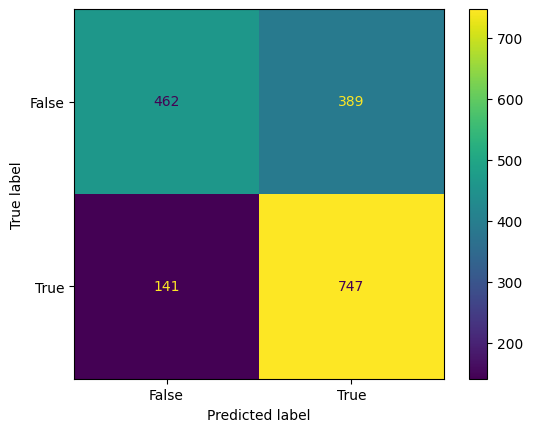

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, test_x, test_y)

In [63]:
#using random forest
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [10, 100, 1000],
              'max_depth': [None, 10, 100, 1000],
                'max_features': ['auto', 'sqrt', 'log2']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, cv=iterations, verbose=3, n_jobs=-1)

start = time.time()
grid.fit(train_x, train_y)
end = time.time()

print(f"Training time: {end - start}s")

Fitting 15 folds for each of 36 candidates, totalling 540 fits


c:\Users\ktmle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Training time: 84.32449388504028s


In [64]:
best_score = grid.best_score_
best_params = grid.best_params_

print(f"Best score: {best_score}")

Best score: 0.800975956406246


In [65]:
with open('result.txt', 'a') as f:
    f.write(f"GridSearch icm RandomForestClassifier\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Best score: {best_score}\n")
    f.write(f"Best params: {best_params}\n")
    f.write(f"Training time: {end - start}s\n\n")

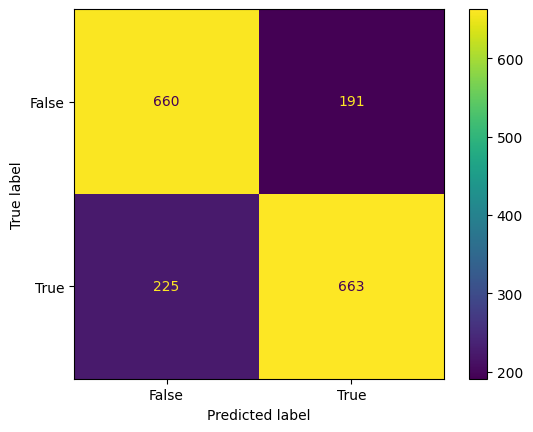

In [66]:
gs_results = pd.DataFrame(grid.cv_results_)
gs_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
gs_results.head()

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, test_x, test_y)

Fitting 15 folds for each of 10 candidates, totalling 150 fits


c:\Users\ktmle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Training time: 48.49923610687256s
Best score: 0.7976682555050769


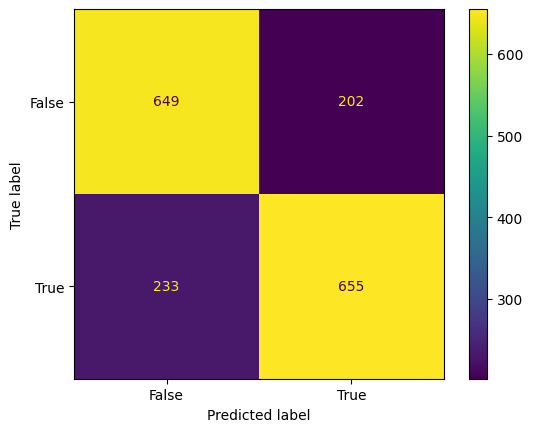

In [67]:
#RandomSearchCV icm RandomForest
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators': [10, 100, 1000],
                'max_depth': [None, 10, 100, 1000],
                    'max_features': ['auto', 'sqrt', 'log2']}

grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, refit=True, cv=iterations, verbose=3, n_jobs=-1)

start = time.time()
grid.fit(train_x, train_y)
end = time.time()

print(f"Training time: {end - start}s")

best_score = grid.best_score_
best_params = grid.best_params_

print(f"Best score: {best_score}")

with open('result.txt', 'a') as f:
    f.write(f"RandomizedSearchCV icm RandomForest\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Best score: {best_score}\n")
    f.write(f"Best params: {best_params}\n")
    f.write(f"Training time: {end - start}s\n\n")

gs_results = pd.DataFrame(grid.cv_results_)
gs_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
gs_results.head()

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, test_x, test_y)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Training time: 299.9586191177368s
Best score: 0.6045424641890718


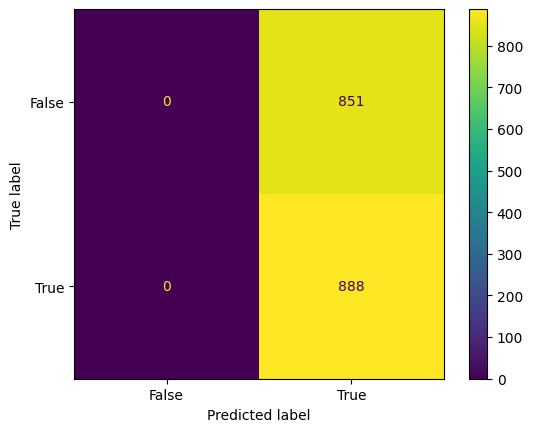

In [68]:
param_grid = {'C': [0.1, 1, 10, 100],
                'degree': [0, 3, 6],
                'kernel':['poly', 'rbf', 'sigmoid']}

grid = RandomizedSearchCV(SVC(), param_grid, refit=True, cv=iterations, verbose=3, n_jobs=-1)

start = time.time()
grid.fit(train_x, train_y)
end = time.time()

print(f"Training time: {end - start}s")

best_score = grid.best_score_
best_params = grid.best_params_

print(f"Best score: {best_score}")

with open('result.txt', 'a') as f:
    f.write(f"RandomizedSearchCV icm SVC\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Best score: {best_score}\n")
    f.write(f"Best params: {best_params}\n")
    f.write(f"Training time: {end - start}s\n\n")

gs_results = pd.DataFrame(grid.cv_results_)
gs_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
gs_results.head()

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, test_x, test_y)